# Exploratory Data Analysis - CAFA 5 Protein Function Analysis Problem

In [1]:
!pip install networkx
!pip install biopython
!pip install obonet
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.0 MB/s eta 0:00:00


## Import Dependecies

In [2]:
from pyvis.network import Network
from random import choice
from Bio import SeqIO
from matplotlib import pyplot as plt
from collections import Counter

import networkx
import numpy as np
import pandas as pd
import obonet

## Config

Here We store the paths to all the files in a ```class Config``` and define ```plot_dag``` for plotting the graph

In [3]:
class Config:
    go_basic_obo_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo"
    train_sequences_fasta_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
    train_terms_tsv_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_taxonomy_tsv_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
    ia_txt_path = "/kaggle/input/cafa-5-protein-function-prediction/IA.txt"

def plot_dag(graph, term, radius=1, filename="network.html"):
    # create a smaller neighbors' graph
    ng_graph = networkx.ego_graph(graph, term, radius)

    # Add the name of the term with its GO code to make thier labels
    for node in ng_graph.nodes(data=True):
        node[1]["label"] = node[0] + " " + node[1]["name"]

    nt = Network(directed=True, notebook=True, cdn_resources="in_line")
    nt.from_nx(ng_graph)

    return nt.show(filename)

## Load the GO Data

Load the ```go_basic.obo``` file as a graph using obonet

In [4]:
graph = obonet.read_obo(Config.go_basic_obo_path)
num_of_terms = len(graph.nodes)

In [5]:
print(f"there are {num_of_terms} GO-terms associated with {len(graph.edges)} connections between them")

there are 43248 GO-terms associated with 84805 connections between them


Chose a random term and see its plot, We can also take some specified node to plot the graph

In [6]:
# chose some random GO term and plot its graph
term = str(choice(list(graph.nodes.keys())))

In [7]:
plot_dag(graph=graph, term=term)

network.html


In [8]:
plot_dag(graph = graph, term = term, radius = 1000)

network.html


## Load the Training Sequences Data

In [9]:
sequences = SeqIO.parse(Config.train_sequences_fasta_path, "fasta")
num_of_proteins = sum(1 for seq in sequences)
print(f"There are {num_of_proteins} protein Sequences given in the file")

There are 142246 protein Sequences given in the file


### Analysis based on length of protein sequences.

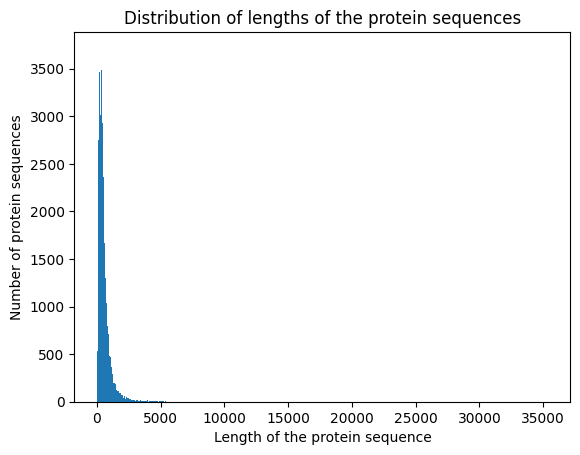

In [10]:
sequences = SeqIO.parse(Config.train_sequences_fasta_path,"fasta")
lengths = [len(seq) for seq in sequences]

plt.hist(lengths, bins="fd")
plt.title("Distribution of lengths of the protein sequences")
plt.xlabel("Length of the protein sequence")
plt.ylabel("Number of protein sequences")
plt.show()

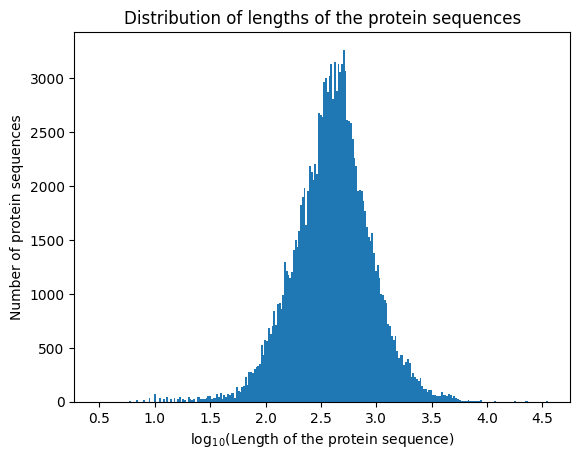

In [11]:
plt.hist(np.log10(lengths), bins="fd")
plt.title("Distribution of lengths of the protein sequences")
plt.xlabel("log$_1$$_0$(Length of the protein sequence)")
plt.ylabel("Number of protein sequences")
plt.show()

The length of a protein appears to follow a log-normal distribution.
The number of sequences with length more than 5K are nearly negligible although the length goes upto 35K.

### Now checking the distribution of various amino acids in the given protein sequences

In [12]:
records = SeqIO.parse(Config.train_sequences_fasta_path,"fasta")
amino_acid_counts = Counter()

for record in records:
    seq = str(record.seq)
    amino_acid_counts.update(seq)


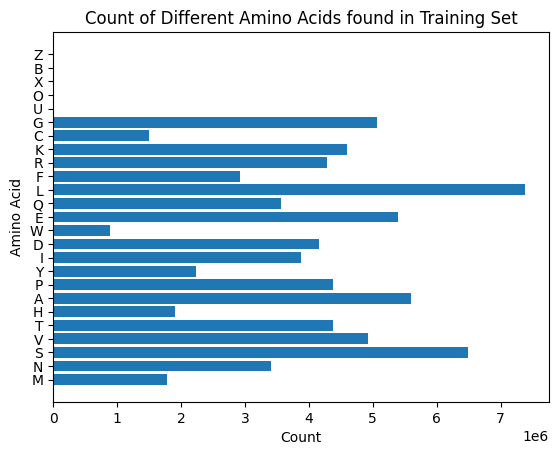

In [13]:
labels = []
sizes = []
for key, value in amino_acid_counts.items():
    labels.append(key)
    sizes.append(value)

plt.barh(labels,sizes)
plt.title("Count of Different Amino Acids found in Training Set")
plt.xlabel("Count")
plt.ylabel("Amino Acid")
plt.show()

* The most common amino acids in this dataset are leucine (L), serine (S), alanine (A), and glycine (G). These amino acids are known to be abundant in proteins and play important roles in protein structure and function.

* The least common amino acids in this dataset are cysteine (C), methionine (M), tryptophan (W), and histidine (H). These amino acids are typically less abundant in proteins, but they can be important for specific functions, such as catalysis, metal binding, or protein-protein interactions.

* The presence of the amino acid selenocysteine (U) in the dataset suggests that some of the proteins may be selenoproteins, which contain selenium in the form of selenocysteine instead of cysteine.

* The presence of ambiguous amino acids (X, B, Z) and rare amino acids (O, U) in the dataset suggests that some of the sequences may be incomplete or contain errors.

## Load Labels Data

In [14]:
train_terms_df = pd.read_csv(Config.train_terms_tsv_path,sep="\t")
train_terms_df.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [15]:
train_terms_df.describe()

,EntryID,term,aspect
count,5363863,5363863,5363863
unique,142246,31466,3
top,Q02248,GO:0005575,BPO
freq,815,92912,3497732


So, there are 142246 proteins annotated by 31466 different GO terms out of 43248.

### pie chart describing the distribution of the different subontologies among different proteins.

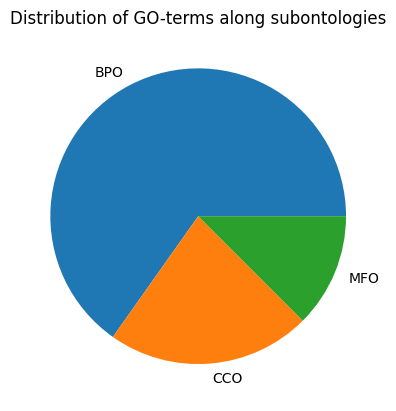

In [16]:
aspect_counts = train_terms_df.aspect.value_counts()
plt.pie(aspect_counts.values,labels=aspect_counts.index)
plt.title("Distribution of GO-terms along subontologies")
plt.show()

## Load Taxonomy Data

In [17]:
taxonomy_df = pd.read_csv(Config.train_taxonomy_tsv_path,sep="\t")
taxonomy_df.head()

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


In [18]:
taxonomy_df.taxonomyID.value_counts()

9606      25125
3702      14461
10090     14384
7955      12671
7227      12020
          ...  
108607        1
683840        1
1542          1
525330        1
489543        1
Name: taxonomyID, Length: 3156, dtype: int64

In [19]:
print("We have about", len(taxonomy_df.taxonomyID.unique()), "different Taxonomy IDs")

We have about 3156 different Taxonomy IDs


## Merge the train labels and the taxonomy data frame.

In [20]:
training_df = pd.merge(train_terms_df,taxonomy_df, on= "EntryID")
training_df.head()

,EntryID,term,aspect,taxonomyID
0,A0A009IHW8,GO:0008152,BPO,1310613
1,A0A009IHW8,GO:0034655,BPO,1310613
2,A0A009IHW8,GO:0072523,BPO,1310613
3,A0A009IHW8,GO:0044270,BPO,1310613
4,A0A009IHW8,GO:0006753,BPO,1310613


### Define prot_vs_terms_analysis to run the proteins-per-term and terms-per-protein analysis

In [21]:
def prot_vs_terms_analysis(df):
    groupby_entryid = df.groupby("EntryID")
    groupby_term = df.groupby("term")

    terms_per_protein = []
    proteins_per_term = []

    for prots in groupby_entryid["term"].unique():
        terms_per_protein.append(len(prots))

    for terms in groupby_term["EntryID"].unique():
        proteins_per_term.append(len(terms))

    terms_per_protein = pd.Series(terms_per_protein)
    proteins_per_term = pd.Series(proteins_per_term)

    print("terms_per_protein.describe()\n")
    print(terms_per_protein.describe())
    print("Median : {}".format(terms_per_protein.median()))

    plt.hist(terms_per_protein,bins="fd")
    plt.title("Distribution of Number of Terms Annotating a protein")
    plt.xlabel("# of terms per unit protein")
    plt.ylabel("frequency")
    plt.show()

    plt.hist(np.log10(terms_per_protein),bins="fd")
    plt.title("Distribution of Number of Terms Annotating a protein")
    plt.xlabel("log$_1$$_0$(# of terms per unit protein)")
    plt.ylabel("frequency")
    plt.show()

    print("proteins_per_term.describe()\n")
    print(proteins_per_term.describe())
    print("Median : {}".format(proteins_per_term.median()))

    plt.hist(np.log10(proteins_per_term),bins="fd")
    plt.title("Distribution of Number of proteins Annotated by a Term")
    plt.xlabel("log$_1$$_0$(# of proteins per term)")
    plt.ylabel("frequency")
    plt.show()

## Perform proteins-per-term and terms-per-protein Analysis

terms_per_protein.describe()

count    142246.000000
mean         37.708357
std          42.524701
min           2.000000
25%          10.000000
50%          24.000000
75%          50.000000
max         815.000000
dtype: float64
Median : 24.0


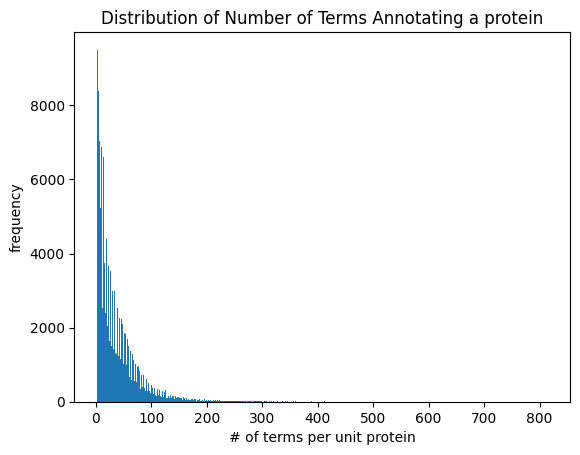

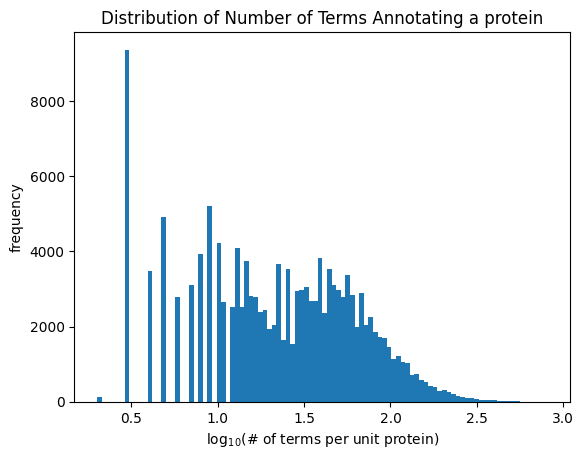

proteins_per_term.describe()

count    31466.000000
mean       170.465359
std       1725.482889
min          1.000000
25%          3.000000
50%          8.000000
75%         35.000000
max      92912.000000
dtype: float64
Median : 8.0


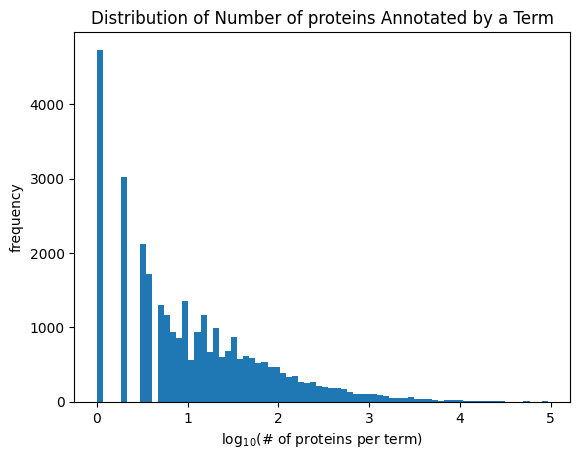

In [22]:
prot_vs_terms_analysis(training_df)

**Number of GO-terms associated to a Protein**
There are about 24(median) terms associated with a protein, as low as 2 terms and high as 815 terms with the average of 37.
The distribution is heavily skewed to the right, and the number of proteins having more than 150-200 terms associated to them are negligible.

**Number of Protiens annotated by a GO-term**
There are about 8(median) proteins annotated by a GO-term but the data is very k=skewed, even so that the graph cannot be plotted linearly and has to be plotted on log-scale.
There are as low as 1 protein and high as 92192 with the average of 170.
Even the 50th percentile is just 8 and the 75th percentile is 35!
The distribution is heavily skewed to the right, and the number of proteins having more than 10^(3.5) = 3000 (approx) terms associated to them are negligible.


## Dividing the dataframe by subontologies

In [23]:
bpo_training_df = training_df[training_df["aspect"] == "BPO"].drop(["aspect"], axis=1)
cco_training_df = training_df[training_df["aspect"] == "CCO"].drop(["aspect"], axis=1)
mfo_training_df = training_df[training_df["aspect"] == "MFO"].drop(["aspect"], axis=1)

### performing the protein vs terms analysis as above with the above Data

In [24]:
pd.DataFrame({"#Prots":[len(bpo_training_df.EntryID.unique()),
                        len(cco_training_df.EntryID.unique()),
                        len(mfo_training_df.EntryID.unique())],
              "#Terms":[len(bpo_training_df.term.unique()),
                        len(cco_training_df.term.unique()),
                        len(mfo_training_df.term.unique())],
              "aspect": ["BPO", "CCO", "MFO"]}).set_index('aspect')

,#Prots,#Terms
aspect,,
BPO,92210,21285
CCO,92912,2957
MFO,78637,7224


### Biological Processes Ontology

terms_per_protein.describe()

count    92210.000000
mean        37.932242
std         38.665120
min          2.000000
25%         14.000000
50%         27.000000
75%         47.000000
max        708.000000
dtype: float64
Median : 27.0


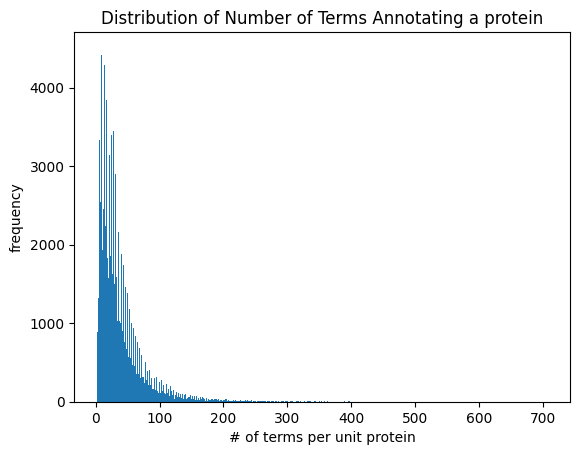

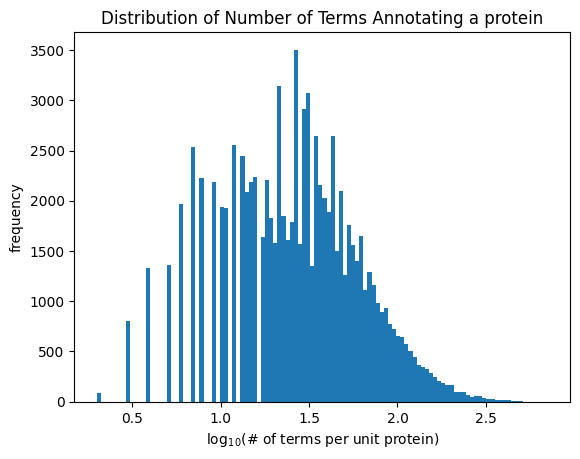

proteins_per_term.describe()

count    21285.000000
mean       164.328494
std       1318.755156
min          1.000000
25%          3.000000
50%         10.000000
75%         42.000000
max      92210.000000
dtype: float64
Median : 10.0


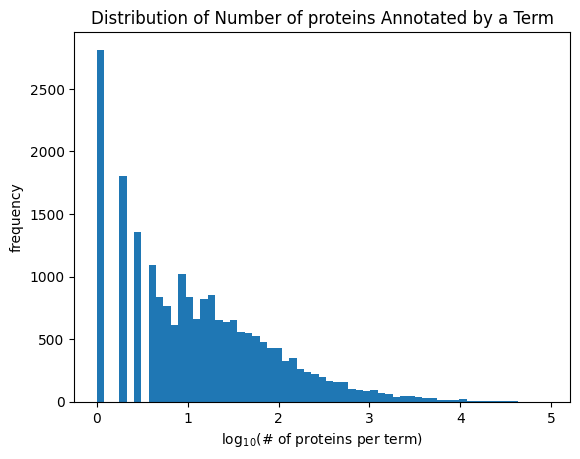

In [25]:
prot_vs_terms_analysis(bpo_training_df)

### Cellular Components Ontology

terms_per_protein.describe()

count    92912.000000
mean        12.872578
std          8.339152
min          2.000000
25%          7.000000
50%         11.000000
75%         17.000000
max        102.000000
dtype: float64
Median : 11.0


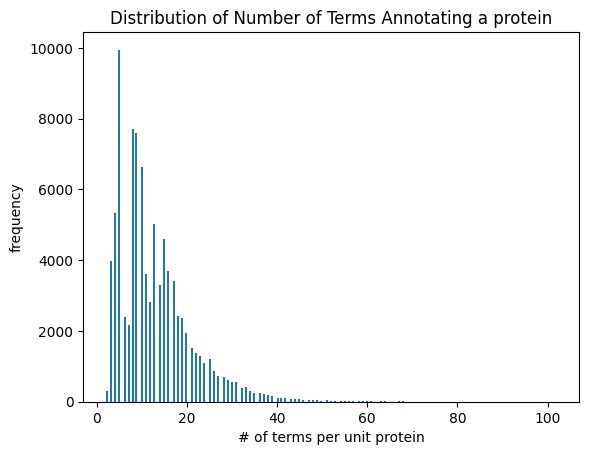

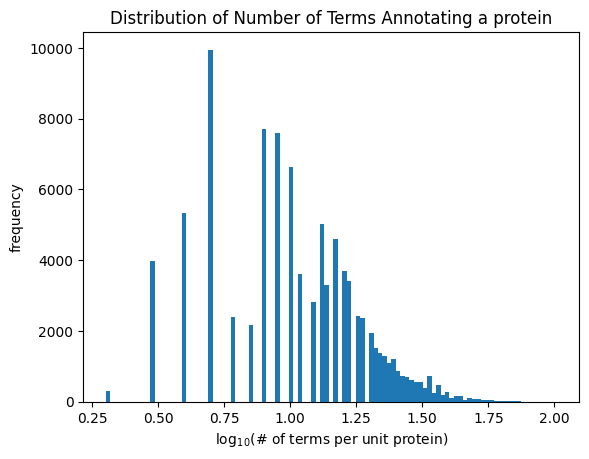

proteins_per_term.describe()

count     2957.000000
mean       404.469733
std       3806.373005
min          1.000000
25%          3.000000
50%          9.000000
75%         42.000000
max      92912.000000
dtype: float64
Median : 9.0


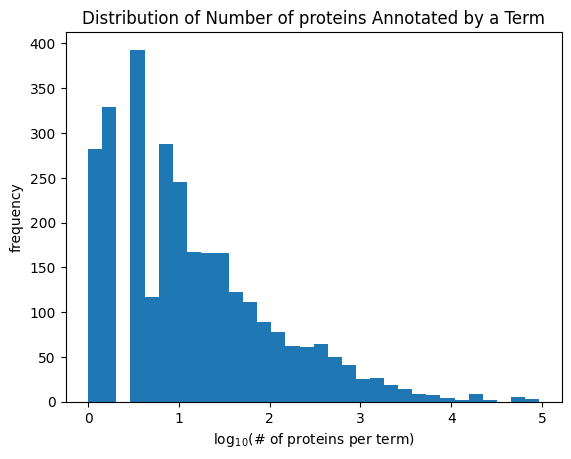

In [26]:
prot_vs_terms_analysis(cco_training_df)

### Molecular Functions Ontology

terms_per_protein.describe()

count    78637.000000
mean         8.521612
std          6.435252
min          2.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         83.000000
dtype: float64
Median : 7.0


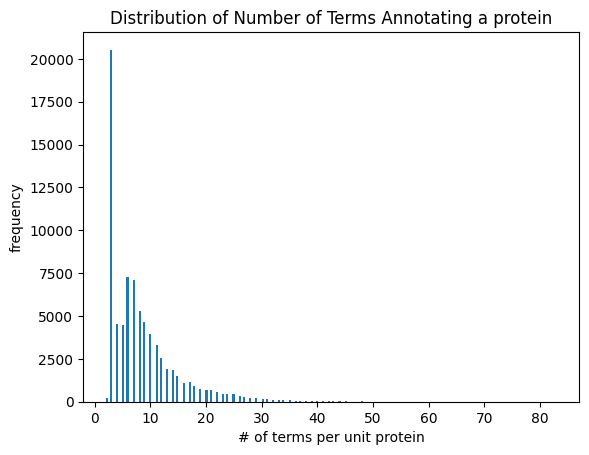

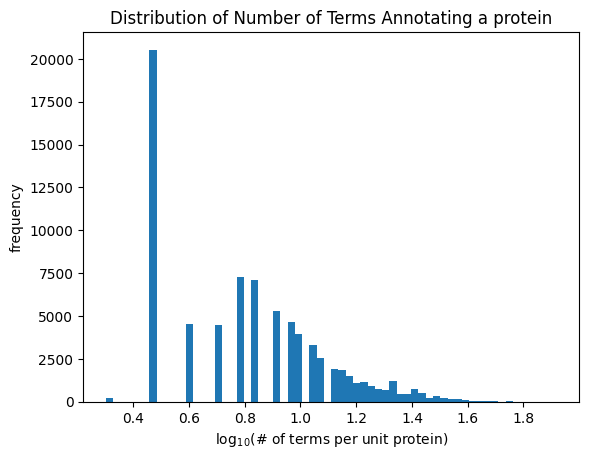

proteins_per_term.describe()

count     7224.000000
mean        92.762182
std       1373.735006
min          1.000000
25%          2.000000
50%          5.000000
75%         15.000000
max      78637.000000
dtype: float64
Median : 5.0


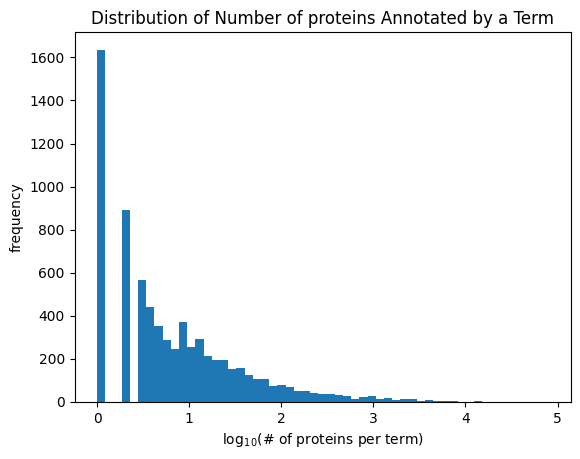

In [27]:
prot_vs_terms_analysis(mfo_training_df)

## Load the Information Accredition Weights of the data

In [28]:
with open(Config.ia_txt_path,"r") as f:
    ia = [x.replace("\n","").split("\t") for x in f.readlines()]

ia = pd.DataFrame(ia, columns=["term","WeightAssigned"])
ia["WeightAssigned"] = ia["WeightAssigned"].astype(np.float64)

### plot of distribution of weights assigned to every GO-term.

In [29]:
ia["WeightAssigned"].describe()

count    43248.000000
mean         2.795279
std          3.346646
min          0.000000
25%          0.000000
50%          1.222392
75%          5.000000
max         16.478122
Name: WeightAssigned, dtype: float64

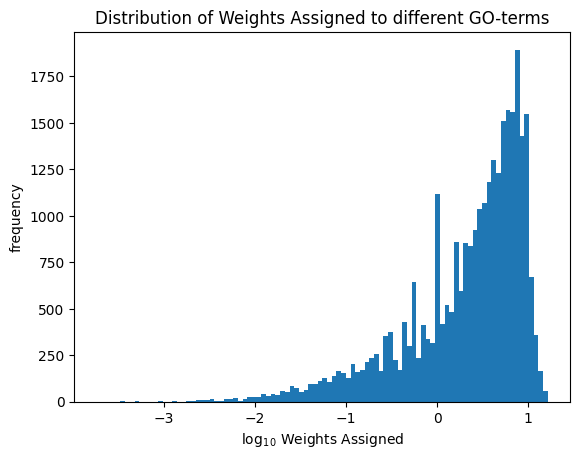

In [30]:
plt.hist(np.log10(ia["WeightAssigned"][ia["WeightAssigned"] != 0]),bins="fd")
plt.title("Distribution of Weights Assigned to different GO-terms")
plt.xlabel("log$_1$$_0$ Weights Assigned")
plt.ylabel("frequency")
plt.show()